# Exploratory data analysis

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

%matplotlib inline

In [ ]:
import os 
os.chdir("../")
bucket = 'aws-project-politomaster-sagemaker-data' 

In [15]:
train_path = os.path.join('s3://', bucket, 'train.csv')
train = pd.read_csv(train_path)
print("Train dataset has: {} rows and {} columns".format(train.shape[0], train.shape[1]))
train.head()

Train dataset has: 43170 rows and 10 columns


,carat_class,cut,color,clarity,depth,table,price,x,y,z
0,low,Ideal,E,SI2,61.746807,54.657905,308.000982,5.087917,4.074514,2.640541
1,low,Premium,E,SI1,60.811398,61.500866,311.972787,4.935622,4.002951,2.566944
2,low,Good,E,VS1,57.463159,64.434528,306.322634,4.836103,3.966641,2.238341
3,low,Premium,I,VS2,62.110048,57.770527,308.236569,5.107297,3.941319,2.476921
4,low,Good,J,SI2,63.367713,58.202601,317.016683,5.348185,4.276069,2.899670


In [16]:
test_path = os.path.join('s3://', bucket, 'test.csv')
test = pd.read_csv(test_path)
print("Test dataset has: {} rows and {} columns".format(test.shape[0], test.shape[1]))
test.head()

Test dataset has: 10770 rows and 10 columns


,carat_class,cut,color,clarity,depth,table,price,x,y,z
0,NaN,Very Good,H,VS1,57.864170,60.877015,312.033984,5.129112,4.053714,2.357030
1,NaN,Good,J,SI1,64.608550,54.823918,321.453496,5.225114,4.298209,2.687131
2,NaN,Ideal,J,VS1,63.515610,56.243782,329.006797,4.946555,3.988157,2.388180
3,NaN,Premium,E,SI2,60.521578,61.481931,322.079563,4.892611,3.802079,2.290711
4,NaN,Premium,E,I1,60.880893,57.886154,318.535695,5.500656,4.425004,2.825893


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43170 entries, 0 to 43169
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   carat_class  43170 non-null  object 
 1   cut          42311 non-null  object 
 2   color        41046 non-null  object 
 3   clarity      41871 non-null  object 
 4   depth        40582 non-null  float64
 5   table        42735 non-null  float64
 6   price        39527 non-null  float64
 7   x            43128 non-null  float64
 8   y            42615 non-null  float64
 9   z            42327 non-null  float64
dtypes: float64(6), object(4)
memory usage: 3.3+ MB


In [6]:
train.describe()

,depth,table,price,x,y,z
count,40582.000000,42735.000000,39527.000000,43128.000000,42615.000000,42327.000000
mean,61.750269,57.453911,3911.581104,6.730082,5.733144,3.538764
std,1.634396,2.255019,3974.925834,1.125322,1.125156,0.724071
min,43.158207,43.321167,306.322634,0.935423,-0.165995,-0.253948
25%,60.805377,55.888065,938.079683,5.703162,4.705580,2.917361
50%,61.807778,57.164165,2392.586880,6.684222,5.687529,3.499653
75%,62.738652,58.878595,5309.267548,7.546948,6.547369,4.057237
max,78.111790,94.856676,18819.121864,11.642644,10.542158,31.908393


In [7]:
train['cut'].value_counts()

Ideal        16892
Premium      10771
Very Good     9508
Good          3885
Fair          1255
Name: cut, dtype: int64

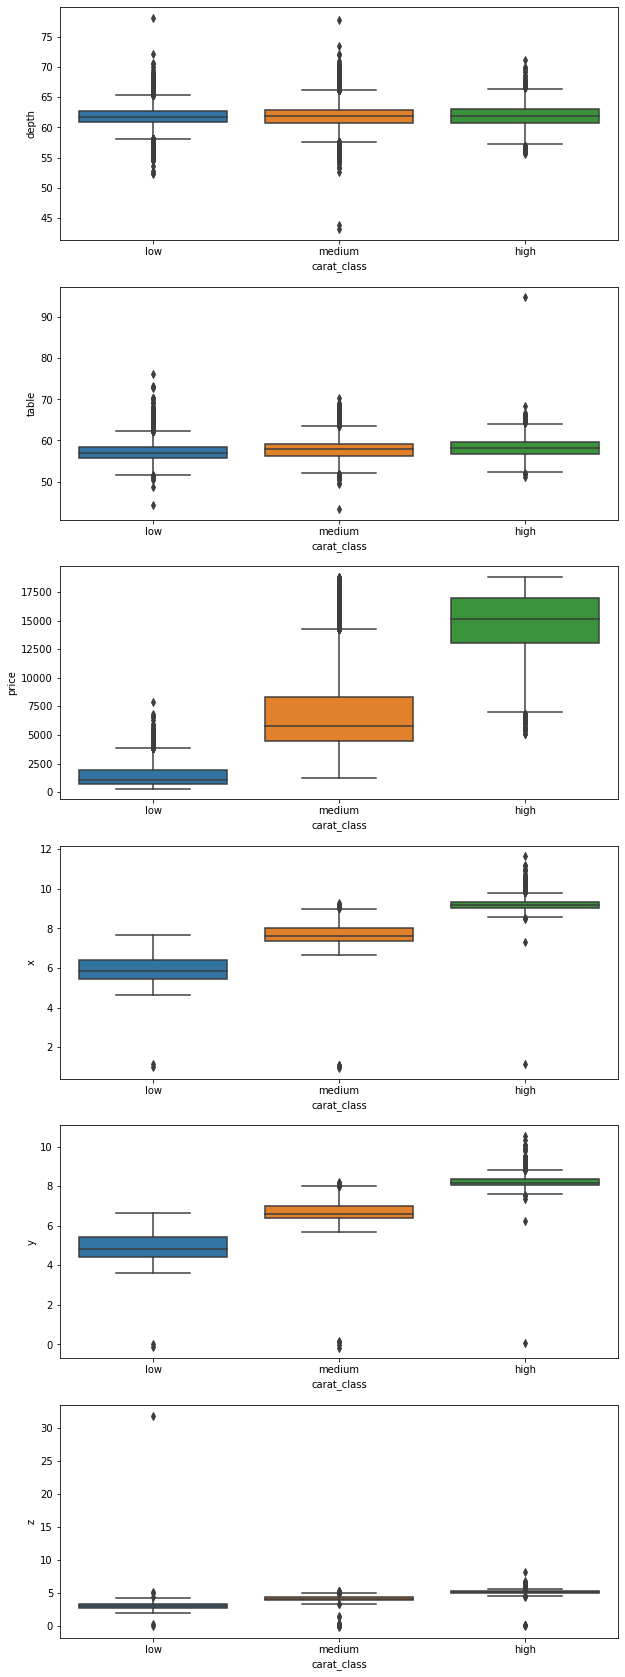

In [8]:
num_features = ['depth','table','price','x','y','z']
fig,ax = plt.subplots(len(num_features),1, figsize = (10,30))
i = 0
for feature in num_features:
    sns.boxplot(x='carat_class', y=feature, data=train, ax = ax[i])
    i = i+1


In [9]:
def preprocess(df, label = True):

    """
    This function allow to customize your preprocessing in order to have data ready for training process
    """
    print('Before dropping duplicates the dataset has {} rows.'.format(df.shape[0]))
    df = df.drop_duplicates().reset_index(drop=True) # drop duplicates 
    
    print('After dropping duplicates the dataset has {} rows.'.format(df.shape[0]))
    
    num_features = ['depth','table','price','x','y','z']
    qualitative_features = ['cut','color','clarity']
    target_feature = 'carat_class'
    
    orders = [['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],
              ['J','I','H','G','F','E','D'],
              ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']]
    
    for feature in num_features:
        #NULL values
        df[feature] = df[feature].fillna(df[feature].mean()) # fill null values with the mean 
        
        #Anomalies
        P10 = df[feature].quantile(0.1) 
        P90 = df[feature].quantile(0.9) 
        df[feature] = df[feature].apply(lambda x: P90 if x > P90 else P10 if x < P10 else x)
        
    for feature,order in zip(qualitative_features,orders):
        #NULL values
        df[feature] = df[feature].fillna(df[feature].mode()) # fill null values with the mode 
        
        #Encoding
        df[feature] = df[feature].astype(pd.CategoricalDtype(categories=order, ordered=True)).cat.codes


    if label: 
        #Encoding
        df[target_feature] = df[target_feature].astype(pd.CategoricalDtype(categories=['low','medium','high'], ordered=True)).cat.codes

    return df

In [10]:
prep_train = preprocess(train)
prep_train.head()

Before dropping duplicates the dataset has 43170 rows.
After dropping duplicates the dataset has 43170 rows.


,carat_class,cut,color,clarity,depth,table,price,x,y,z
0,0,4,5,1,61.746807,54.834605,651.357414,5.350743,4.352193,2.667488
1,0,3,5,2,60.811398,60.300733,651.357414,5.350743,4.352193,2.667488
2,0,1,5,4,59.799569,60.300733,651.357414,5.350743,4.352193,2.667488
3,0,3,1,3,62.110048,57.770527,651.357414,5.350743,4.352193,2.667488
4,0,1,0,1,63.367713,58.202601,651.357414,5.350743,4.352193,2.899670


In [11]:
display(train['carat_class'].value_counts())
display(prep_train['carat_class'].value_counts())

low       25498
medium    15893
high       1779
Name: carat_class, dtype: int64

0    25498
1    15893
2     1779
Name: carat_class, dtype: int64

In [13]:
prep_test = preprocess(test, label = False)
prep_test.head()

Before dropping duplicates the dataset has 10770 rows.
After dropping duplicates the dataset has 10770 rows.


,carat_class,cut,color,clarity,depth,table,price,x,y,z
0,NaN,2,2,4,59.836140,60.324462,647.878069,5.356124,4.352648,2.673524
1,NaN,1,0,2,63.571754,54.854762,647.878069,5.356124,4.352648,2.687131
2,NaN,4,0,4,63.515610,56.243782,647.878069,5.356124,4.352648,2.673524
3,NaN,3,5,1,60.521578,60.324462,647.878069,5.356124,4.352648,2.673524
4,NaN,3,5,0,60.880893,57.886154,647.878069,5.500656,4.425004,2.825893


In [18]:
import io
import boto3


#Path files of the dataframe
train_path_file = 'preprocess/prep_train.csv'

#Put dataframes to S3
csv_buffer = io.StringIO()
prep_train.to_csv(csv_buffer, index=False)
csv_buffer.seek(0)
boto3.resource('s3').Object(bucket, train_path_file).put(Body=csv_buffer.getvalue())

#Path files of the dataframe
test_path_file = 'preprocess/prep_test.csv'

#Put dataframes to S3
csv_buffer = io.StringIO()
prep_test.to_csv(csv_buffer, index=False)
csv_buffer.seek(0)
boto3.resource('s3').Object(bucket, test_path_file).put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'TCJX182EP8YK5GZV',
  'HostId': 'n0giseMi+vRw8IPPbPy23J4a2bBxbE2UvfUyHxw/ChzQg8e4gA9vzVCDtS/ZX0dEUqa2c2EG3NM=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'n0giseMi+vRw8IPPbPy23J4a2bBxbE2UvfUyHxw/ChzQg8e4gA9vzVCDtS/ZX0dEUqa2c2EG3NM=',
   'x-amz-request-id': 'TCJX182EP8YK5GZV',
   'date': 'Sat, 03 Jul 2021 10:16:15 GMT',
   'etag': '"ccadf216589914c97f1866e0af5c7406"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"ccadf216589914c97f1866e0af5c7406"'}

In [ ]:
prep_train_path = os.path.join('s3://', bucket, 'preprocess/prep_train.csv')
prep_train = pd.read_csv(prep_train_path)
print("Prep_train dataset has: {} rows and {} columns".format(prep_train.shape[0], prep_train.shape[1]))
prep_train.head()

In [ ]:
prep_test_path = os.path.join('s3://', bucket, 'preprocess/prep_test.csv')
prep_test = pd.read_csv(prep_test_path)
print("Prep_test dataset has: {} rows and {} columns".format(prep_test.shape[0], prep_test.shape[1]))
prep_train.head()

In [ ]:
sns.set(rc={'figure.figsize':(10,8)})
fig, ax = plt.subplots(1, 1)
sns.heatmap(prep_train.corr(), vmin = -1, vmax= 1 , annot = True)
sns.set_context("notebook", rc={"font.size":12,"axes.titlesize":20,"axes.labelsize":16}) 
plt.setp(ax.get_yticklabels(),rotation=45)
plt.setp(ax.get_xticklabels(),rotation=45)
#plt.savefig("images/trainingCorr.png")
plt.show()

In [ ]:
features = list(prep_train.columns)[1::]
n_features = len(features)
fig,ax = plt.subplots(n_features,1, figsize = (10,50))

for feature, i in zip(features,range(n_features)):
    sns.boxplot(x='carat_class', y=feature, data=prep_train, ax = ax[i])


In [76]:
!pip install imblearn

     |████████████████████████████████| 206 kB 19.2 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
from sklearn.svm import SVC
from sklearn.metrics import r2_score, mean_squared_error, max_error, accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import plot_confusion_matrix
from imblearn.pipeline import make_pipeline

from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE



In [ ]:
seed = 0

target = prep_train['carat_class']
data = prep_train.drop(labels = ['carat_class'],axis = 1)
sample_train, sample_val, label_train, label_val = \
    train_test_split(data, target, test_size=0.3, random_state=seed)

In [16]:
# Standardize all numerical features
std_scale = StandardScaler().fit(sample_train)
scaled_train = std_scale.transform(sample_train)
scaled_val = std_scale.transform(sample_val)

Time:  5.67027735710144
rmse:  0.037680487993205156
r2:  0.8875917657277117
max_error:  1
accuracy_score:  0.9623195120067949




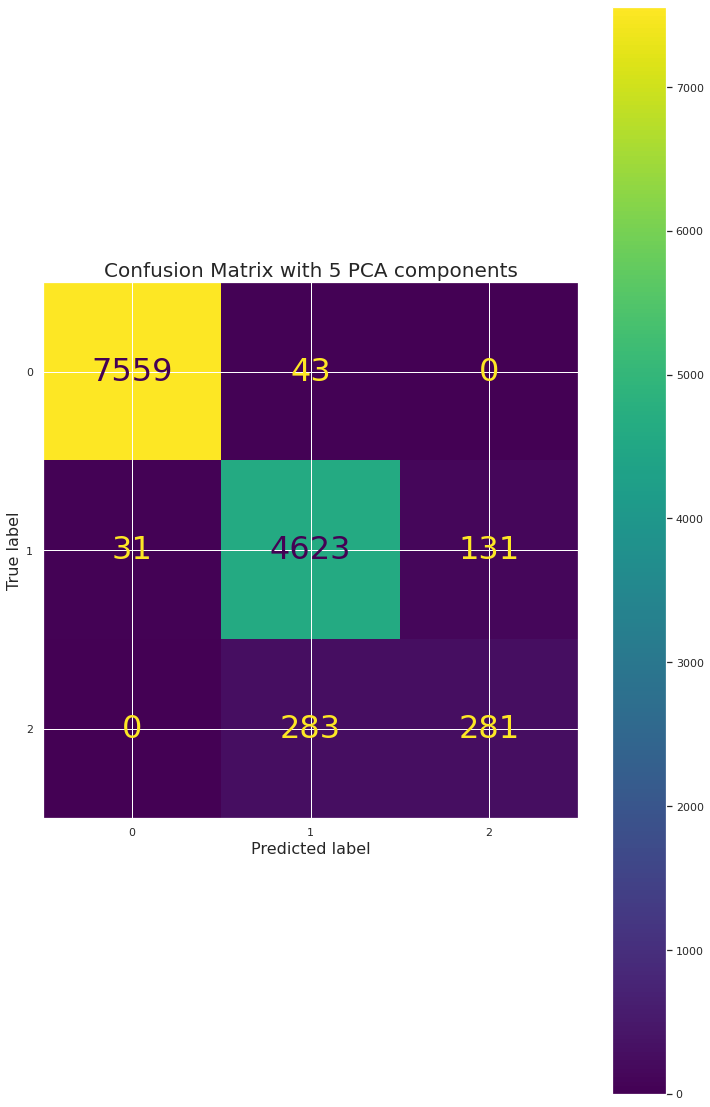

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7602
           1       0.93      0.97      0.95      4785
           2       0.68      0.50      0.58       564

    accuracy                           0.96     12951
   macro avg       0.87      0.82      0.84     12951
weighted avg       0.96      0.96      0.96     12951



In [74]:
balanced = False

rmse_list = []
r2_list = []
accuracy_list = []
precision_list = []
recall_list = []

for feature_dim in range(5,6):
    #feature_dim = 4
    """
    Perform PCA in order to reduce the dataset dimensionality.
    """
    pca = PCA(n_components=feature_dim).fit(scaled_train)
    pca_train = pca.transform(scaled_train)
    pca_val = pca.transform(scaled_val)

    #pca.explained_variance_ratio_
    """
    Take a balanced set of 
    """
    if balanced:
        _, train_counts = np.unique(label_train, return_counts=True)
        train_n = train_counts.min()

        train_mask = np.hstack([np.random.choice(np.where(label_train == l)[0], train_n, replace=False)
                              for l in np.unique(label_train)])
        train_mask

        _, val_counts = np.unique(label_val, return_counts=True)
        val_n = val_counts.min()

        val_mask = np.hstack([np.random.choice(np.where(label_val == l)[0], val_n, replace=False)
                              for l in np.unique(label_val)])
        val_mask
    else:
        train_mask = np.array(range(pca_train.shape[0]))
        val_mask = np.array(range(pca_val.shape[0]))
    
    X_train = pca_train[train_mask]
    X_val = pca_val[val_mask]

    y_train = label_train.to_numpy()[train_mask]
    y_val = label_val.to_numpy()[val_mask]


    t0 = time.time()

    reg = SVC(gamma='auto',kernel='linear', C = 1.0, random_state = seed)
    reg = reg.fit(X=X_train,y=y_train)
    reg.score(X_train,y_train)
    pred = reg.predict(X_val)
    t1 = time.time()

    rmse = mean_squared_error(y_val,pred)
    r2 = r2_score(y_val,pred)
    max_err = max_error(y_val,pred)
    acc = accuracy_score(y_val,pred)
    precision = precision_score(y_val,pred,average = 'micro')
    recall = recall_score(y_val,pred,average = 'micro')
    print('Time: ', t1-t0)
    print('rmse: ', rmse)
    print('r2: ', r2)
    print('max_error: ', max_err)
    print('accuracy_score: ', acc)
    print('\n')
    rmse_list.append(rmse)
    r2_list.append(r2)
    accuracy_list.append(acc)
    precision_list.append(precision)
    recall_list.append(recall)
    
    plot_confusion_matrix(reg, pca_val, label_val)  
    plt.title('Confusion Matrix with ' + str(feature_dim) + ' PCA components')
    plt.show()
    
    print(classification_report(y_val,pred))

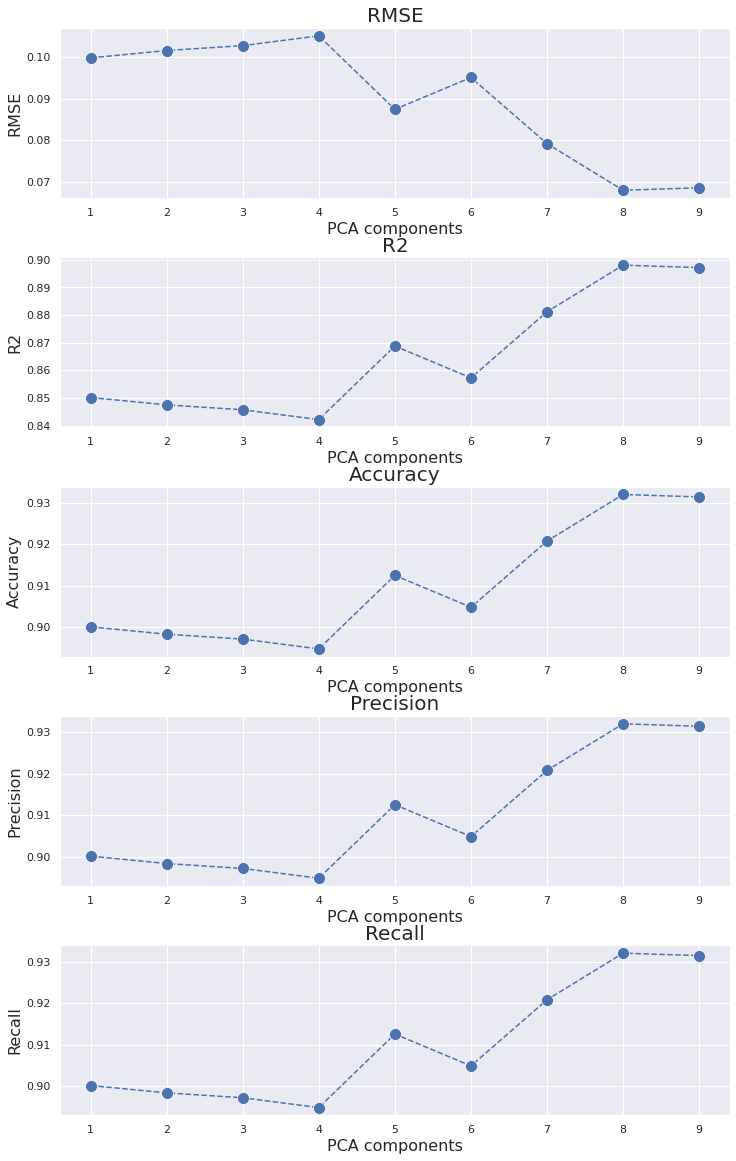

In [66]:
sns.set(rc={'figure.figsize':(12,20)})
sns.set_context("notebook", rc={"font.size":32,"axes.titlesize":20,"axes.labelsize":16})
fig, ax = plt.subplots(5,1)

for i,feature,result_list in zip(range(5),['RMSE','R2','Accuracy','Precision','Recall'],
                                 [rmse_list, r2_list, accuracy_list,precision_list,recall_list]):
    sns.lineplot(x = range(1,10), y = result_list,
                 marker='o',markersize=12,linestyle='dashed', ax = ax[i])
    ax[i].set(ylabel=feature, xlabel='PCA components', title=feature)
    
plt.subplots_adjust(hspace = 0.35)
#plt.savefig("images/SparkLearningCurve.png")  
plt.show()

In [21]:
t0 = time.time()

reg = SVC(gamma='auto',kernel='linear', C = 1.0, random_state = seed)
reg = reg.fit(X=pca_train,y=label_train)
reg.score(pca_train,label_train)
pred = reg.predict(pca_val)
t1 = time.time()

rmse = mean_squared_error(label_val,pred)
r2 = r2_score(label_val,pred)
max_err = max_error(label_val,pred)
acc = accuracy_score(label_val,pred)
precision = precision_score(y_val,pred,average = 'micro')
recall = recall_score(y_val,pred,average = 'micro')
print('Time: ', t1-t0)
print('rmse: ', rmse)
print('r2: ', r2)
print('max_error: ', max_err)
print('accuracy_score: ', acc)
print('precision_score: ', precision)
print('recall_score: ', recall)
print('\n')

Time:  6.118898391723633
rmse:  0.03713998919002394
r2:  0.8892041789242404
max_error:  1
accuracy_score:  0.9628600108099761




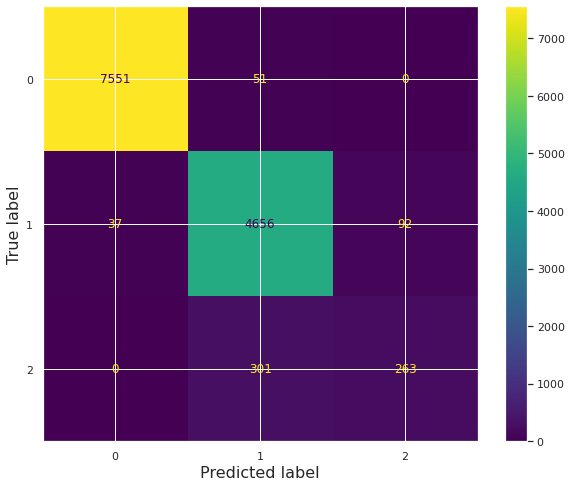

In [22]:
plot_confusion_matrix(reg, pca_val, label_val)  
plt.show()

In [ ]:
std_scale = StandardScaler()
pca = PCA(n_components=5)
enn = EditedNearestNeighbours()
smote = SMOTE(random_state=0)
reg = SVC(gamma='auto',kernel='linear', C = 1.0, random_state = seed)

model = make_pipeline(pca, enn, reg)

#sample_train, sample_val, label_train, label_val
model.fit(sample_train, label_train)
y_pred = model.predict(sample_val)
print(classification_report(label_val, y_pred))